Remarks: 
* The input files 'data/data_files/wiki_categories/all_categories_count.csv' and 'data/data_files/wiki_categories/all_categories_origins.csv' stemm from API calls done by the notebook wiki_cat_top_head.ipynb 
* Input file '/data/data_files/wiki_categories/german_cats.ttl' stems from the German Wikipedia Dump mentioned in the paper

# Setup

## Function Setup

In [33]:
import re
from collections import defaultdict
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import pandas as pd
import numpy as np

In [34]:
def plot_similarity_heatmap(similarity_matrix, labels):
    # Make a copy of the similarity matrix to avoid modifying the original
    similarity_matrix_copy = np.copy(similarity_matrix)

    # Set diagonal elements to NaN
    np.fill_diagonal(similarity_matrix_copy, np.nan)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(similarity_matrix_copy,
                     annot=True,
                     cmap="YlGnBu",
                     linewidths=0.5,
                     xticklabels=labels,
                     yticklabels=labels,
                     mask=np.isnan(similarity_matrix_copy))
    ax.set_title("Cosine Similarity")
    plt.show()

def extract_categories_df(filename):
    category_pattern = re.compile(r'<http://de.dbpedia.org/resource/Kategorie:(.*?)>')
    article_pattern = re.compile(
        r'<http://de.dbpedia.org/resource/(.*?)> <http://purl.org/dc/terms/subject>')
    category_counter = defaultdict(int)
    article_set = set()

    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            # Extract and count categories
            category_matches = category_pattern.findall(line)
            for match in category_matches:
                category_counter[match] += 1

            # Extract articles
            article_match = article_pattern.search(line)
            if article_match:
                article_set.add(article_match.group(1))

    # Sort the categories by count in descending order
    sorted_categories = sorted(category_counter.items(), key=lambda x: x[1], reverse=True)

    # Calculate category shares
    total_categories = sum(category_counter.values())

    category_shares = [((category, count, (round(count / total_categories * 100, 2))))
                       for category, count in sorted_categories]

    # Count the number of different articles
    unique_article_count = len(article_set)

    # Create a dataframe containing the category, size, and share
    df = pd.DataFrame(category_shares, columns=['category', 'size', 'share'])

    return df


def calculate_cosine_similarity(df1, df2, df3, df4):
    # Combine the dataframes into a list
    dfs = [df1, df2, df3, df4]

    # Merge the dataframes and fill missing values with zeros
    merged_df = pd.concat(dfs, axis=0, keys=range(len(dfs)), names=["df_idx"])
    merged_df = merged_df.reset_index(level="df_idx").pivot_table(values="size",
                                                                  index="category",
                                                                  columns="df_idx",
                                                                  fill_value=0)

    # Calculate the pairwise cosine similarity
    similarities = cosine_similarity(merged_df.T)

    return similarities


def gini_coefficient(array):
    array = np.sort(array)
    n = len(array)
    index = np.arange(1, n + 1)
    gini = (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))
    return gini


def calculate_descriptive_statistics_gini(df1, df2, df3, df4, labels):
    dfs = [df1, df2, df3, df4]

    # Prepare an empty list to store the statistics for each dataframe
    stats_list = []

    for idx, df in enumerate(dfs):
        # Quantiles of share value
        quantiles = df['share'].quantile([0.99, 0.999, 0.9999])

        # Gini coefficient
        gini_coeff = gini_coefficient(df['share'].values)

        # Count of different categories
        category_count = len(df)

        # Add the calculated statistics to the list
        stats_list.append({
            'label': labels[idx],
            '99_share': quantiles[0.99],
            '999_share': quantiles[0.999],
            '9999_share': quantiles[0.9999],
            'avg_cat_per_art': sum(df['size']),
            'category_count': category_count
        })

    # Convert the statistics list into a dataframe
    stats_df = pd.DataFrame(stats_list)

    return stats_df

## Data Setup

In [35]:
filename = os.getcwd() + '/data/data_files/wiki_categories/german_cats.ttl'
df = extract_categories_df(filename)

df = df.rename(columns={'Share':'share','Category':'category','Size':'size'})

origin_df = pd.read_csv('data/data_files/wiki_categories/all_categories_origins.csv')

exec_df = origin_df[origin_df['category_counter origin']=='excellent']
read_df = origin_df[origin_df['category_counter origin']=='readworthy']
prot_df = origin_df[origin_df['category_counter origin']=='protected']

In [36]:
count_df = pd.read_csv('data/data_files/wiki_categories/all_categories_count.csv')
count_df = count_df[~count_df['category'].str.startswith('Wikipedia')]
exec_count_df = count_df[count_df['article origin']=='excellent']
read_count_df = count_df[count_df['article origin']=='readworthy']
prot_count_df = count_df[count_df['article origin']=='protected']
df_cathead = df.copy()
df_cathead['share'] = df_cathead['size']/2443797
exec_count_df['share'] = exec_count_df['size']/2778
read_count_df['share'] = read_count_df['size']/4324
prot_count_df['share'] = prot_count_df['size']/2845

/tmp/ipykernel_5592/1738084304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec_count_df['share'] = exec_count_df['size']/2778
/tmp/ipykernel_5592/1738084304.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  read_count_df['share'] = read_count_df['size']/4324
/tmp/ipykernel_5592/1738084304.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

# Results

## Per article level

###  Top categories by % of articles they are attached to

In [37]:
print("Excellent articles: ")
exec_count_df.head(10)

Excellent articles: 


,category,size,article origin,share
1,Mann,431,excellent,0.155148
6,Deutscher,138,excellent,0.049676
12,Autor,84,excellent,0.030238
13,Person als Namensgeber für einen Asteroiden,83,excellent,0.029878
14,US-Amerikaner,75,excellent,0.026998
16,Literatur (20. Jahrhundert),66,excellent,0.023758
17,Literatur (Deutsch),64,excellent,0.023038
22,Frau,50,excellent,0.017999
23,Literarisches Werk,50,excellent,0.017999
26,Disposition einer Orgel,38,excellent,0.013679


In [38]:
print("Readworthy articles: ")
read_count_df.head(10)

Readworthy articles: 


,category,size,article origin,share
11342,Mann,597,readworthy,0.138067
11345,Deutscher,234,readworthy,0.054117
11352,Frau,127,readworthy,0.029371
11355,Autor,112,readworthy,0.025902
11357,US-Amerikaner,99,readworthy,0.022895
11361,Kirchengebäude in Europa,75,readworthy,0.017345
11363,Person als Namensgeber für einen Asteroiden,71,readworthy,0.016420
11364,Literatur (Deutsch),68,readworthy,0.015726
11365,Disposition einer Orgel,68,readworthy,0.015726
11368,Literatur (20. Jahrhundert),62,readworthy,0.014339


In [39]:
print("All articles Wikidump: ")
df_cathead.head(10)

All articles Wikidump: 


,category,size,share
0,Mann,698459,0.285809
1,Deutscher,285651,0.116888
2,Frau,140559,0.057517
3,US-Amerikaner,106458,0.043563
4,Autor,64265,0.026297
5,Abkürzung,49397,0.020213
6,Filmschauspieler,47231,0.019327
7,Brite,39832,0.016299
8,Österreicher,36271,0.014842
9,Franzose,33191,0.013582


In [40]:
print("Protected articles: ")
prot_count_df.head(10)

Protected articles: 


,category,size,article origin,share
28299,Mann,488,protected,0.171529
28300,Deutscher,301,protected,0.105800
28304,Frau,119,protected,0.041828
28305,Begriffsklärung,114,protected,0.040070
28311,Autor,85,protected,0.029877
28313,Pseudonym,71,protected,0.024956
28315,Filmschauspieler,70,protected,0.024605
28316,US-Amerikaner,69,protected,0.024253
28317,Literatur (Deutsch),66,protected,0.023199
28319,Person als Namensgeber für einen Asteroiden,64,protected,0.022496


## Share over all category-mentions

### Descriptive Statistics category share

In [41]:
labels = ['Proteced','Excellent', 'Readworthy',  'Wikidump']
statistics_df = calculate_descriptive_statistics_gini(prot_df,exec_df,read_df,df ,labels)
display(statistics_df)

,label,99_share,999_share,9999_share,avg_cat_per_art,category_count
0,Proteced,0.07,0.41512,2.111440,15583,8489
1,Excellent,0.05,0.16000,0.695896,18931,11177
2,Readworthy,0.03,0.13000,0.560398,28912,16747
3,Wikidump,0.00,0.02000,0.083341,11985666,386660


### Cosine similarity category share:

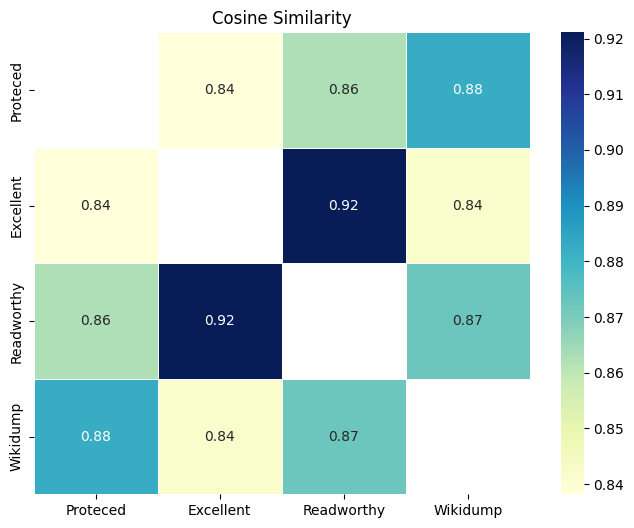

In [42]:
similarities = calculate_cosine_similarity(prot_df,exec_df,read_df,df)
labels = ['Proteced','Excellent', 'Readworthy',  'Wikidump']
plot_similarity_heatmap(similarities, labels)